#### [ 공공 데이터 분석 - 온도 데이터 ]
- 데이터 : 기상청 사이트

[1] 모듈 로딩 및 데이터 준비 <hr>

In [941]:
## 모듈 로딩
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib

In [942]:
## 데이터 준비
DATA_FILE = '../data/대구기온_2000_20251109.csv'
daeguDF = pd.read_csv(DATA_FILE,skiprows=7)
daeguDF.head()

,날짜,지점,평균기온(℃),최저기온(℃),최고기온(℃)
0,\t2000-01-01,143,4.7,0.0,8.5
1,\t2000-01-02,143,6.5,3.1,11.5
2,\t2000-01-03,143,2.9,0.0,6.8
3,\t2000-01-04,143,2.3,-2.4,7.5
4,\t2000-01-05,143,4.9,-0.9,9.4


[2] 데이터 확인 <hr>

In [943]:
## 요약 정보 확인
daeguDF.info()

## => 날짜 컬럼 앞부분 '\t'공백 제거
## => 지점 컬럼 대구코드값 불필요한 컬럼 제거

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9445 entries, 0 to 9444
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   날짜       9445 non-null   object 
 1   지점       9445 non-null   int64  
 2   평균기온(℃)  9444 non-null   float64
 3   최저기온(℃)  9445 non-null   float64
 4   최고기온(℃)  9443 non-null   float64
dtypes: float64(3), int64(1), object(1)
memory usage: 369.1+ KB


[3] 기본 전처리 => 불필요 컬럼과 데이터 삭제<hr>

In [944]:
## 지점 컬럼 대구 코드값 불필요한 컬럼 제거 : drop(axis = 1 또느 'columns')
df = daeguDF.copy()
df = df.drop(columns = '지점')

# 날짜 컬럼에 앞에 붙은 '\t' 제거 => 날짜 컬럼 타입 objcet로 str
# 접근자 str사용
# df['날짜'] = df['날짜'].str.replace('\t','')
df['날짜'] = df['날짜'].str.strip()

df.head(3)


,날짜,평균기온(℃),최저기온(℃),최고기온(℃)
0,2000-01-01,4.7,0.0,8.5
1,2000-01-02,6.5,3.1,11.5
2,2000-01-03,2.9,0.0,6.8


In [945]:
df.head(3), df.tail(3)


(           날짜  평균기온(℃)  최저기온(℃)  최고기온(℃)
 0  2000-01-01      4.7      0.0      8.5
 1  2000-01-02      6.5      3.1     11.5
 2  2000-01-03      2.9      0.0      6.8,
               날짜  평균기온(℃)  최저기온(℃)  최고기온(℃)
 9442  2025-11-07     13.1      7.7     20.6
 9443  2025-11-08     12.9      7.8     18.3
 9444  2025-11-09     14.6     11.1     19.3)

[3] 세부 전처리 <hr>
- 결측치/중복값/이상치

In [946]:
## -------------------------
## 결측치 체크
## -------------------------


df.isna().sum()

날짜         0
평균기온(℃)    1
최저기온(℃)    0
최고기온(℃)    2
dtype: int64

In [947]:
## 결측치 존재 행 추출 => 필터링
# df[(df['최고기온(℃)'].isna() ==True)] | (df['평균기온(℃)'].isna() ==True)

msDF = df[df.isna().any(axis=1)]
msDF

,날짜,평균기온(℃),최저기온(℃),최고기온(℃)
5021,2013-09-30,NaN,20.1,NaN
8817,2024-02-21,5.1,3.6,NaN


In [948]:
df.iloc[8817][df.iloc[8817].isna()].index

Index(['최고기온(℃)'], dtype='object')

In [949]:
## 데이터의 특성 즉, 기온 무작위성 X => 같은 컬럼의 값들이 서로 연결성
## 삭제하지 않고 채우기 => 이전/이후값들의 평균값으로 채우기
for idx in msDF.index :
    ## 결측치 존재 컬럼명 추출
    cols = df.iloc[idx][df.iloc[idx].isna()].index

    ## 결측치 존재 행의 앞/뒤 3개행 선택 => 평균 : {컬럼명:평균값,...}
    fill_values = df[cols].iloc[idx-1:idx+2].mean(numeric_only= True).to_dict()
    df.loc[idx]= df.iloc[idx].fillna(fill_values)

## 결측치 대체 확인
df.isna().sum()


날짜         0
평균기온(℃)    0
최저기온(℃)    0
최고기온(℃)    0
dtype: int64

In [950]:
## any() : 행/열 방향으로 원소가 1개이상 True면 True
## all() : 행/열 방향으로 원소가 모두 True면 True
## ※ 주의 ※
## -> 행 단위일 경우 axis=1 : 행을 구성하는 모든 원소 즉, 모든 컬럼값을 확인
## -> 열 단위일 경우 axis=0 : 열을 구성하는 모든 원소 즉, 모든 행의 값들 확인
df.isna().any(axis=1)

0       False
1       False
2       False
3       False
4       False
        ...  
9440    False
9441    False
9442    False
9443    False
9444    False
Length: 9445, dtype: bool

In [951]:
## -------------------------------------------
## 중복값 체크 : 기온 데이터는 중복 발생 가능. 유지
## -------------------------------------------
print(daeguDF.columns)

## 20000101 ~ 20251109
duDF = df[df.duplicated(subset=df.columns[1:],keep=False)]
duDF.sort_values(by=['평균기온(℃)'])

Index(['날짜', '지점', '평균기온(℃)', '최저기온(℃)', '최고기온(℃)'], dtype='object')


,날짜,평균기온(℃),최저기온(℃),최고기온(℃)
1839,2005-01-13,-1.2,-3.9,2.5
5452,2014-12-05,-1.2,-3.9,2.5
2239,2006-02-17,-1.0,-3.7,2.7
9185,2025-02-23,-1.0,-3.7,2.7
6965,2019-01-26,-0.3,-3.5,4.6
...,...,...,...,...
3853,2010-07-20,29.1,24.8,34.2
4967,2013-08-07,30.0,23.8,36.2
2001,2005-06-24,30.0,23.8,36.2
4939,2013-07-10,30.7,26.2,35.9


In [952]:
## 이상치 체크
import sys
sys.path.append(r'C:\Users\lsj03\Desktop\KDT_10SL\EX_DATA_ANALYSYS\Utils')
import datautil as du

In [953]:
# du.get_outlier_records(df, df.columns[1:])


C:\Users\lsj03\AppData\Local\Temp\ipykernel_23908\3500095633.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\lsj03\AppData\Local\Temp\ipykernel_23908\3500095633.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(msDF[data_name], labels=data_name)


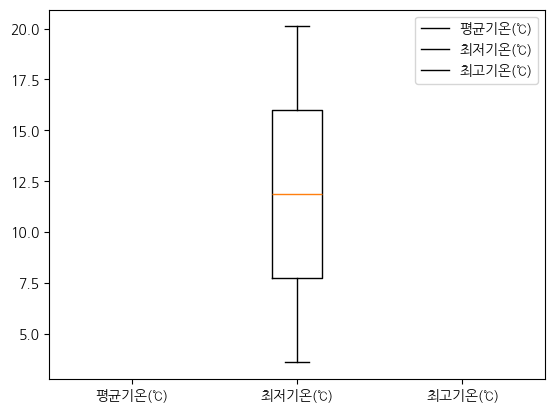

In [954]:
## 컬럼별 이상치 Boxplot 체크
data_name=['평균기온(℃)','최저기온(℃)','최고기온(℃)']
plt.legend()
plt.boxplot(msDF[data_name], labels=data_name)
plt.legend(data_name)
plt.show()

[4] 탐색적분석(EDA)<hr>

In [955]:
## 날짜 컬럼 : object ==> str이지만 날짜를 의미 : datetime64[ns]
df.날짜 = pd.to_datetime(daeguDF.날짜)

print(f'0번 원소 : {df.날짜[0]} / {type(df.날짜[0])}')

## 타입 체크
df.info()

0번 원소 : 2000-01-01 00:00:00 / <class 'pandas._libs.tslibs.timestamps.Timestamp'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9445 entries, 0 to 9444
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   날짜       9445 non-null   datetime64[ns]
 1   평균기온(℃)  9445 non-null   float64       
 2   최저기온(℃)  9445 non-null   float64       
 3   최고기온(℃)  9445 non-null   float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 295.3 KB


In [956]:
## ---------------------------------------------------------------------
## 날짜 컬럼 일단위 ==> 주기 (주 W, 월 M, 분기 Q, 년도 Y)
## ---------------------------------------------------------------------
## Period 배열 만들기
pr_m = pd.period_range( start=df['날짜'].iloc[0],
                       end=df['날짜'].iloc[-1],
                       freq = '2Q')
print(pr_m, pr_m.shape,range(1,pr_m.shape[0]+1))
print(pr_m[0], type(pr_m[0]))

PeriodIndex(['2000Q1', '2000Q3', '2001Q1', '2001Q3', '2002Q1', '2002Q3',
             '2003Q1', '2003Q3', '2004Q1', '2004Q3', '2005Q1', '2005Q3',
             '2006Q1', '2006Q3', '2007Q1', '2007Q3', '2008Q1', '2008Q3',
             '2009Q1', '2009Q3', '2010Q1', '2010Q3', '2011Q1', '2011Q3',
             '2012Q1', '2012Q3', '2013Q1', '2013Q3', '2014Q1', '2014Q3',
             '2015Q1', '2015Q3', '2016Q1', '2016Q3', '2017Q1', '2017Q3',
             '2018Q1', '2018Q3', '2019Q1', '2019Q3', '2020Q1', '2020Q3',
             '2021Q1', '2021Q3', '2022Q1', '2022Q3', '2023Q1', '2023Q3',
             '2024Q1', '2024Q3', '2025Q1', '2025Q3'],
            dtype='period[2Q-DEC]') (52,) range(1, 53)
2000Q1 <class 'pandas._libs.tslibs.period.Period'>


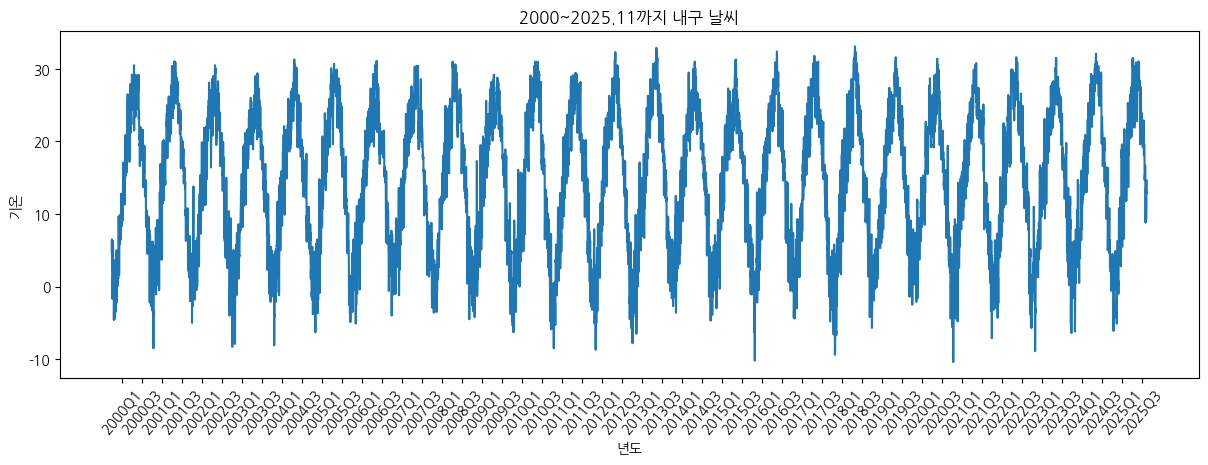

In [964]:
## 전체적인 대구시의 2000.1.1 ~ 2025.11.9까지 기온변화
## => 시간에 따른 흐름 : 선그래프
## => X축 : 날짜  Y축 : 기온 평균/최저/최고
plt.figure(figsize=(12,4))
plt.plot(df['날짜'],df['평균기온(℃)'])
plt.tight_layout()
plt.ylabel('기온')
plt.xlabel('년도')
plt.title('2000~2025.11까지 내구 날씨')
plt.xticks(pr_m, pr_m, rotation=50)
plt.show()


In [958]:
## [문제] 2000~2025년도 최고온도/최저온도/평균온도 변화 시각화
# df = df.set_index("날짜")
## dt 접근자 => 년, 월, 일 추출
df['년'] = df['날짜'].dt.year

## => 그룹화
# df1 = df.groupby('년')['평균기온(℃)'].mean()
# df2 = df.groupby('년')['최고기온(℃)'].max()
# df3 = df.groupby('년')['최저기온(℃)'].min()
# df5 = df.groupby('년')[['평균기온(℃)','최고기온(℃)','최저기온(℃)']].mean()
# df4 = pd.concat([df1,df2,df3],axis = 1)
func_dict= dict(zip(df.columns[1:], ['mean','min','max']))
resultDF = df[df.columns[1:]].groupby(['년']).agg(func_dict)
resultDF.head()

,평균기온(℃),최저기온(℃),최고기온(℃)
년,,,
2000,14.287432,-7.9,35.0
2001,14.889863,-11.7,35.8
2002,14.192603,-8.5,35.4
2003,13.789041,-10.9,34.7
2004,14.866120,-11.8,36.9


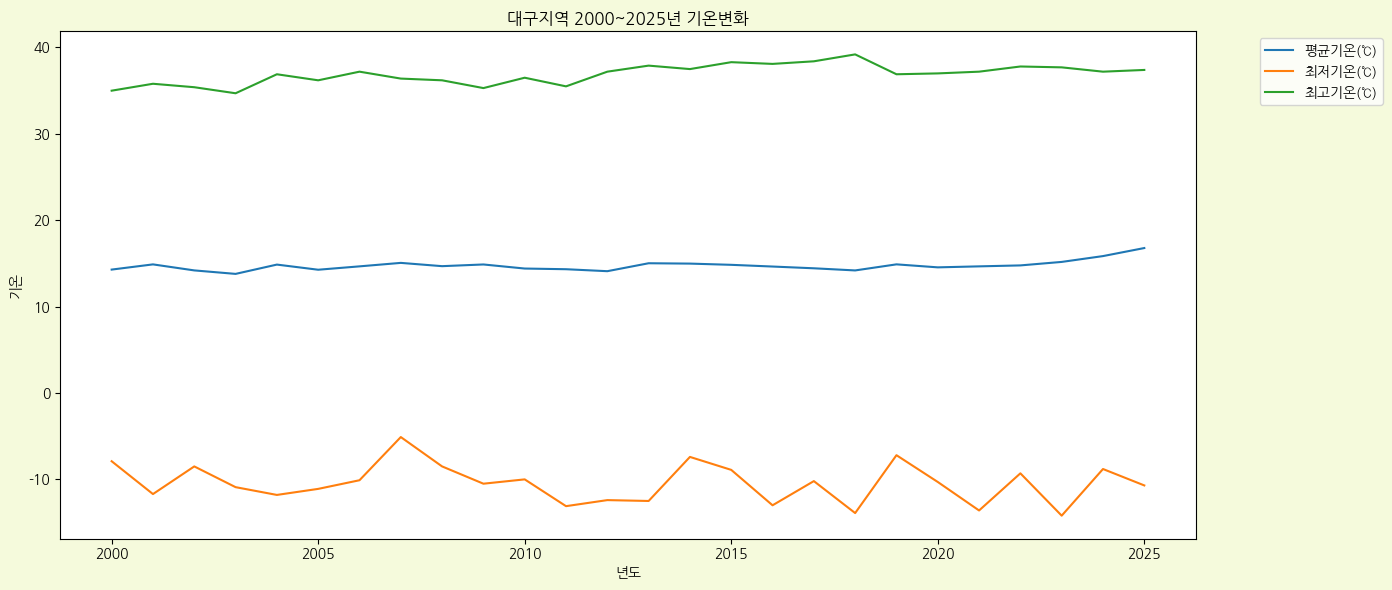

In [962]:
## => 시각화
plt.figure(figsize=(14,6), facecolor = '#F5FADC')

for col in resultDF.columns :
    colDF = resultDF.loc[:,col]
    plt.plot(colDF.index, colDF, label=col)

plt.legend(bbox_to_anchor=(1.05,1.))
plt.title("대구지역 2000~2025년 기온변화")
plt.xlabel('년도')
plt.ylabel('기온')
plt.tight_layout()
plt.show()

In [ ]:
## [과제] 여름이 길어지고 겨울이 짧아짐 => 25도 이상인 일수
